<a href="https://colab.research.google.com/github/wpocl/topological-data-analysis/blob/main/03-practice_model_with_topological_signatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install giotto-tda

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from gtda.homology import CubicalPersistence

from google.colab import drive

In [ ]:
plt.style.use("ggplot")

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/mnist/train.csv")
test = pd.read_csv("/content/drive/MyDrive/mnist/test.csv")

In [ ]:
train_images = train.drop(columns="label").values
train_labels = train["label"].values

In [ ]:
# Normalise the train images
train_images = train_images / 255

In [ ]:
# Reshape to image format
train_images = train_images.reshape(-1, 1, 28, 28)

In [ ]:
cubical = CubicalPersistence(homology_dimensions=[0])

In [ ]:
train_diagrams = cubical.fit_transform(train_images)
train_diagrams = train_diagrams[:, :, :2]

In [ ]:
#@title
import torch
import numpy as np
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch import Tensor

In [ ]:
#@title
def prepare_batch(batch, point_dim):
    """
    This method 'vectorizes' the multiset in order to take advances of GPU
    processing. The policy is to embed all multisets in batch to the highest
    dimensionality occurring in batch, i.e., ``max(t.size()[0]`` for ``t`` in batch).

    Args:
        batch:
            The input batch to process as a list of tensors.

        point_dim:
            The dimension of the points the inputs consist of.

    Returns:
        A four-tuple consisting of (1) the constructed ``batch``, i.e., a
        tensor with size
        ``batch_size`` x ``n_max_points`` x ``point_dim``; (2) a tensor
        ``not_dummy`` of size ``batch_size`` x ``n_max_points``, where
        ``1`` at position (i,j) indicates if the point is a dummy point,
        whereas ``0`` indicates a dummy point used for padding; (3)
        the max. number of points and (4) the batch size.

    Example::

        >>> from torchph.nn.slayer import prepare_batch
        >>> import torch
        >>> x = [torch.rand(10,2), torch.rand(20,2)]
        >>> batch, not_dummy, max_pts, batch_size = prepare_batch(x)
    """
    if point_dim is None:
        point_dim = batch[0].size(1)
    assert (all(x.size(1) == point_dim for x in batch if len(x) != 0))

    batch_size = len(batch)
    batch_max_points = max([t.size(0) for t in batch])
    input_device = batch[0].device

    if batch_max_points == 0:
        # if we are here, batch consists only of empty diagrams.
        batch_max_points = 1

    # This will later be used to set the dummy points to zero in the output.
    not_dummy_points = torch.zeros(
        batch_size,
        batch_max_points,
        device=input_device)

    prepared_batch = []

    for i, multi_set in enumerate(batch):
        n_points = multi_set.size(0)

        prepared_dgm = torch.zeros(
            batch_max_points,
            point_dim,
            device=input_device)

        if n_points > 0:
            index_selection = torch.tensor(range(n_points),
                                           device=input_device)

            prepared_dgm.index_add_(0, index_selection, multi_set)

            not_dummy_points[i, :n_points] = 1

        prepared_batch.append(prepared_dgm)

    prepared_batch = torch.stack(prepared_batch)

    return prepared_batch, not_dummy_points, batch_max_points, batch_size


def is_prepared_batch(input):
    if not (isinstance(input, tuple) and len(input) == 4):
        return False
    else:
        batch, not_dummy_points, max_points, batch_size = input
        return isinstance(batch, Tensor) and isinstance(not_dummy_points, Tensor) and max_points > 0 and batch_size > 0


def is_list_of_tensors(input):
    try:
        return all([isinstance(x, Tensor) for x in input])

    except TypeError:
        return False


def prepare_batch_if_necessary(input, point_dimension=None):
    batch, not_dummy_points, max_points, batch_size = None, None, None, None

    if is_prepared_batch(input):
        batch, not_dummy_points, max_points, batch_size = input
    elif is_list_of_tensors(input):
        if point_dimension is None:
            point_dimension = input[0].size(1)

        batch, not_dummy_points, max_points, batch_size = prepare_batch(
            input,
            point_dimension)

    else:
        raise ValueError(
            'SLayer does not recognize input format! Expecting [Tensor] or \
             prepared batch. Not {}'.format(input))

    return batch, not_dummy_points, max_points, batch_size


def parameter_init_from_arg(arg, size, default, scalar_is_valid=False):
    if isinstance(arg, (int, float)):
        if not scalar_is_valid:
            raise ValueError('Scalar initialization values are not valid. \
                              Got {} expected Tensor of size {}.'
                             .format(arg, size))
        return torch.Tensor(*size).fill_(arg)
    elif isinstance(arg, torch.Tensor):
        assert(arg.size() == size)
        return arg
    elif arg is None:
        if default in [torch.rand, torch.randn, torch.ones, torch.ones_like]:
            return default(*size)
        else:
            return default(size)
    else:
        raise ValueError('Cannot handle parameter initialization. \
                          Got "{}" '.format(arg))

# endregion

In [ ]:
#@title
class SLayerExponential(Module):
    """
    Proposed input layer for multisets [1].
    """
    def __init__(self, n_elements: int,
                 point_dimension: int=2,
                 centers_init: Tensor=None,
                 sharpness_init: Tensor=None):
        """
        Args:
            n_elements:
                Number of structure elements used.

            point_dimension: D
                Dimensionality of the points of which the
                input multi set consists of.

            centers_init:
                The initialization for the centers of the structure elements.

            sharpness_init:
                Initialization for the sharpness of the structure elements.
        """
        super().__init__()

        self.n_elements = n_elements
        self.point_dimension = point_dimension

        expected_init_size = (self.n_elements, self.point_dimension)

        centers_init = parameter_init_from_arg(
            centers_init,
            expected_init_size,
            torch.rand, scalar_is_valid=False)
        sharpness_init = parameter_init_from_arg(
            sharpness_init,
            expected_init_size,
            lambda size: torch.ones(*size)*3)

        self.centers = Parameter(centers_init)
        self.sharpness = Parameter(sharpness_init)

    def forward(self, input)->Tensor:
        batch, not_dummy_points, max_points, batch_size = prepare_batch_if_necessary(
            input,
            point_dimension=self.point_dimension)

        batch = torch.cat([batch] * self.n_elements, 1)

        not_dummy_points = torch.cat([not_dummy_points] * self.n_elements, 1)

        centers = torch.cat([self.centers] * max_points, 1)
        centers = centers.view(-1, self.point_dimension)
        centers = torch.stack([centers] * batch_size, 0)

        sharpness = torch.pow(self.sharpness, 2)
        sharpness = torch.cat([sharpness] * max_points, 1)
        sharpness = sharpness.view(-1, self.point_dimension)
        sharpness = torch.stack([sharpness] * batch_size, 0)

        x = centers - batch
        x = x.pow(2)
        x = torch.mul(x, sharpness)
        x = torch.sum(x, 2)
        x = torch.exp(-x)
        x = torch.mul(x, not_dummy_points)
        x = x.view(batch_size, self.n_elements, -1)
        x = torch.sum(x, 2)
        x = x.squeeze()

        return x

    def __repr__(self):
        return 'SLayerExponential (... -> {} )'.format(self.n_elements)

In [ ]:
class TestModel(nn.Module):
  def __init__(self):
    super(TestModel, self).__init__()

    self.slayer = SLayerExponential(32, 2)

    self.dropout1 = nn.Dropout(0.2)
    self.norm1 = nn.BatchNorm1d(32)
    self.fc1 = nn.Linear(32, 64)
    self.relu1 = nn.ReLU()

    self.dropout2 = nn.Dropout(0.1)
    self.norm2 = nn.BatchNorm1d(64)
    self.fc2 = nn.Linear(64, 64)
    self.relu2 = nn.ReLU()

    self.dropout3 = nn.Dropout(0.1)
    self.norm3 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 32)
    self.relu3 = nn.ReLU()

    self.fc4 = nn.Linear(32, 10)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.slayer(x)

    x = self.dropout1(x)
    x = self.norm1(x)
    x = self.fc1(x)
    x = self.relu1(x)

    x = self.dropout2(x)
    x = self.norm2(x)
    x = self.fc2(x)
    x = self.relu2(x)

    x = self.dropout3(x)
    x = self.norm3(x)
    x = self.fc3(x)
    x = self.relu3(x)

    x = self.fc4(x)
    x = self.softmax(x)

    return x

In [ ]:
# One hot encoding
y_train_oh = torch.eye(10)[train_labels]

In [ ]:
train_diagrams = torch.Tensor(train_diagrams)

In [ ]:
model = TestModel()

In [ ]:
model = model.to(device)

In [ ]:
train_diagrams = train_diagrams.to(device)

In [ ]:
y_train_oh = y_train_oh.to(device)

In [ ]:
num_epochs = 30
batch_size = 250

In [ ]:
num_samples = train_diagrams.shape[0]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
for epoch in range(num_epochs):
    for start_index in range(0, num_samples, batch_size):
        end_index = start_index + batch_size
        if end_index > num_samples: continue
        X_batch = train_diagrams[start_index: end_index]
        y_batch = y_train_oh[start_index: end_index]

        # Forward pass
        y_batch_ = model(X_batch)
        loss = criterion(y_batch_, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
y_train_oh_ = model(train_diagrams)

In [ ]:
y_train_ = torch.argmax(y_train_oh_, dim=1).cpu().numpy()

In [ ]:
accuracy = accuracy_score(train_labels, y_train_)

print(f"Training accuracy: {accuracy}")

Training accuracy: 0.29947619047619045


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

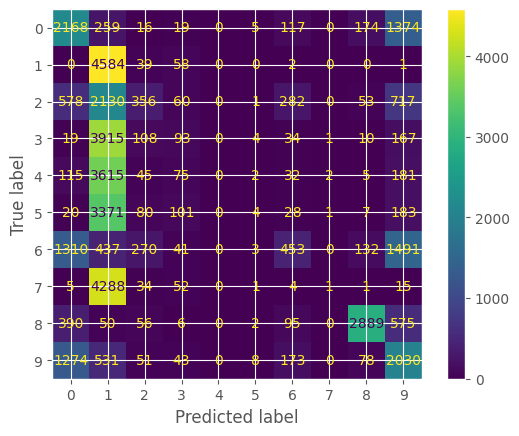

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(train_labels, y_train_))
disp.plot()